In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.optimize import curve_fit
import numpy as np
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.tsa.stattools as tools

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

In [5]:
"""Poniższa praca zawiera dopasowanie modelu ARMA do danych z różnych stacji badawczych zawierających stężenie jonu amonowego (NH4) w wodzie. Wysokie stężenia NH4 wskazuje na dużą ilość zanieczyszczeń."""

'Poniższa praca zawiera dopasowanie modelu ARMA do danych z różnych stacji badawczych zawierających stężenie jonu amonowego (NH4) w wodzie. Wysokie stężenia NH4 wskazuje na dużą ilość zanieczyszczeń.'

In [7]:

data = pd.read_csv('data//PB_1996_2019_NH4.csv', sep=';')

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
for station in data['ID_Station'].unique():
    station_data = data[data['ID_Station'] == station]
    plt.plot(station_data.index, station_data['NH4'], label=f'Stacja {station}')

plt.title('Stężenie związku NH4 dla różnych stacji badawczych')
plt.xlabel('Data')
plt.ylabel('Stężenie NH4 (mg/L)')
plt.legend()
plt.grid(True)
plt.legend(fontsize='small')  

plt.show()

NameError: name 'plt' is not defined

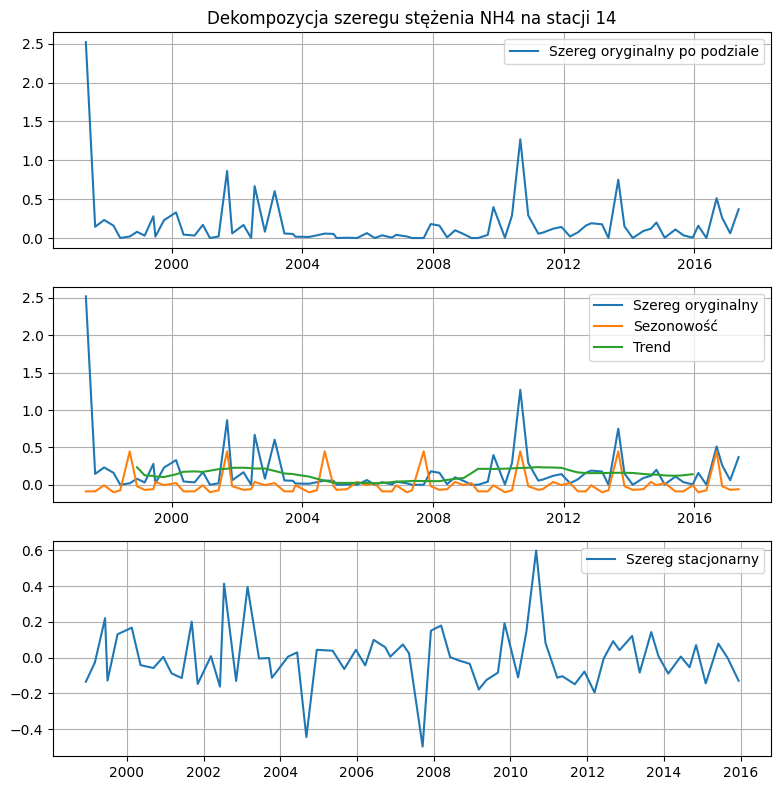

In [ ]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('data//PB_1996_2019_NH4.csv', sep=';')

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data_sorted = data.sort_values(by='Date')

# podzial na dane testowe i treningowe 
train_data, test_data = train_test_split(data_sorted, test_size=0.1, shuffle=False)

# Funkcja do dekompozycji szeregu czasowego (rozkład na 3 komponenty: trend, sezonowość i reszty/residua)
def decomposition_func(station):
    station_data = train_data[train_data['ID_Station'] == station]
    station_data.set_index('Date', inplace=True)
    station_data = station_data.dropna()
    decomposition = seasonal_decompose(station_data['NH4'], model='additive', period=12)  # Okres = 12 miesięcy
    plt.figure(figsize=(8, 8))
    # szereg oryginalny

    plt.subplot(311)
    plt.title(f"Dekompozycja szeregu stężenia NH4 na stacji {station}")

    plt.plot(station_data.index, station_data['NH4'], label='Szereg oryginalny po podziale', linewidth=3/2)
    plt.grid()
    plt.legend(loc='best')

    # dekompozycja szeregu z podzialem na 3 komponenty
    plt.subplot(312)
    plt.plot(station_data.index, station_data['NH4'], label='Szereg oryginalny', linewidth=3/2)
    plt.plot(station_data.index, decomposition.seasonal,label='Sezonowość')
    plt.plot(station_data.index, decomposition.trend, label='Trend')

    plt.legend(loc='best')
    plt.grid()

    plt.subplot(313)
    # szereg po usunieciu sezonowosci i trendu
    station_data['NH4_detrended_deseasonalized'] = station_data['NH4'] - decomposition.trend - decomposition.seasonal

    plt.plot(station_data.index, station_data['NH4_detrended_deseasonalized'], label='Szereg stacjonarny', linewidth=3/2)
    plt.legend(loc='best')
    plt.grid()

    plt.tight_layout()


# Badanie sezonowości dla stacji numer 14
decomposition_func(14)
plt.show()

C:\Users\mkosi\AppData\Local\Temp\ipykernel_7136\542448174.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_14_data['Date'] = pd.to_datetime(station_14_data['Date'], format='%d.%m.%Y')


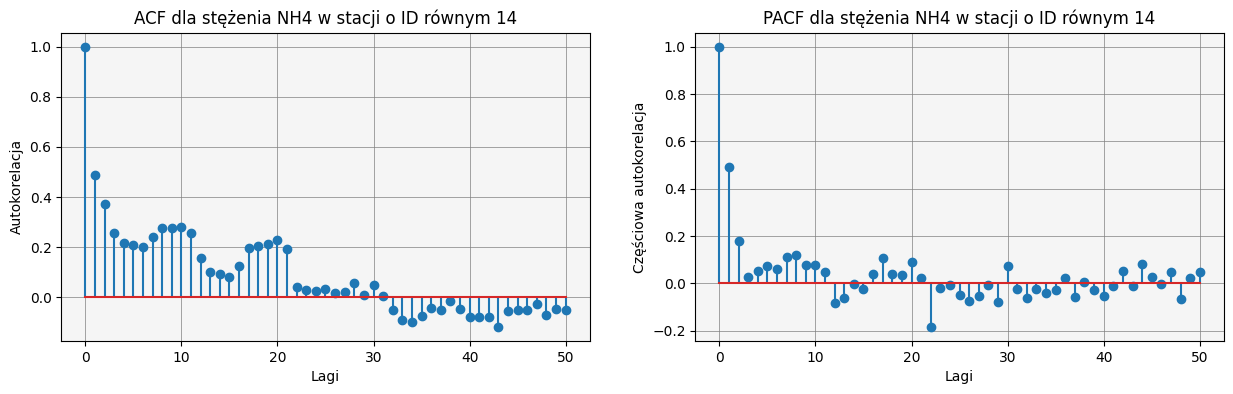

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

# Wybór danych dla stacji o ID równym 14
station_14_data = data[data['ID_Station'] == 16]

# Konwersja kolumny 'Date' na typ daty
station_14_data['Date'] = pd.to_datetime(station_14_data['Date'], format='%d.%m.%Y')

# Ustawienie kolumny 'Date' jako indeks
station_14_data.set_index('Date', inplace=True)

# Obliczenie funkcji autokorelacji
lags = min(len(station_14_data['NH4']) // 2, 50)  # liczba opóźnień
acf_values = acf(station_14_data['NH4'], nlags=lags)
pacf_values = pacf(station_14_data['NH4'], nlags=lags)

# Wykresy funkcji autokorelacji
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
plt.stem(range(lags + 1), acf_values)
plt.xlabel('Lagi')
plt.ylabel('Autokorelacja')
plt.title('ACF dla stężenia NH4 w stacji o ID równym 14')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')

plt.subplot(1,2,2)
plt.stem(range(lags + 1), pacf_values)
plt.xlabel('Lagi')
plt.ylabel('Częściowa autokorelacja')
plt.title('PACF dla stężenia NH4 w stacji o ID równym 14')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('whitesmoke')
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Funkcja do przeprowadzenia testu ADF
def perform_adf_test(data):
    result = adfuller(data)
    print('Test Statistic:', result[0])
    print('P-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:', result[4])

    # Interpretacja wyników
    if result[1] <= 0.05:
        print("Odrzucamy hipotezę o niestacjonarności. Dane są stacjonarne.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy o niestacjonarności. Dane są niestacjonarne.")

# Test ADF dla danych ze stacji o ID równym 14
print("Test ADF dla stężenia NH4 w stacji o ID równym 14:")
perform_adf_test(station_14_data['NH4'])

Test ADF dla stężenia NH4 w stacji o ID równym 14:
Test Statistic: -3.2028941133713213
P-value: 0.019817766566530576
Lags Used: 12
Critical Values: {'1%': -3.4524113009049935, '5%': -2.8712554127251764, '10%': -2.571946570731871}
Odrzucamy hipotezę o niestacjonarności. Dane są stacjonarne.


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Definicja maksymalnych wartości p, d i q
max_p = 4
max_d = 4
max_q = 4

best_aic = float("inf")
best_order = None

# Iteracja po możliwych wartościach p, d i q
for p in range(max_p + 1):
    for d in range(max_d + 1):
        for q in range(max_q + 1):
            # Sprawdzenie, czy przynajmniej jedna z wartości p, d lub q jest różna od zera
            if p != 0 or d != 0 or q != 0:
                try:
                    # Dopasowanie modelu ARIMA dla danej kombinacji p, d i q
                    model = ARIMA(station_14_data['NH4'], order=(p, d, q))
                    model_fit = model.fit()
                    # Sprawdzenie czy AIC jest niższe od aktualnie najlepszego
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                except:
                    continue

print("Najlepszy model ARIMA:", best_order)
print("Wartość AIC:", best_aic)

c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provide

Najlepszy model ARIMA: (1, 0, 3)
Wartość AIC: -563.837283249821


c:\Users\mkosi\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
import pmdarima as pm

model2 = pm.auto_arima(station_14_data['NH4'], 
                      d=0,
                      start_p=0, start_q=0, max_d=0, 
                      max_p=4, max_q=4, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                      stepwise=False
                      )

# print model summary
print(model2.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-331.687, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-432.894, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-481.348, Time=0.06 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-496.715, Time=0.06 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-505.015, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-513.860, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-546.639, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-556.517, Time=0.12 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-561.641, Time=0.21 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-559.749, Time=0.31 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-535.029, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-560.727, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-559.809, Time=0.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-559.141, Time=0.23 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-557.872, Time=0.40 sec
 ARIMA(3,0

# Szukanie modelu ARMA

## 0. Stężenia NH4 dla różnych stacji

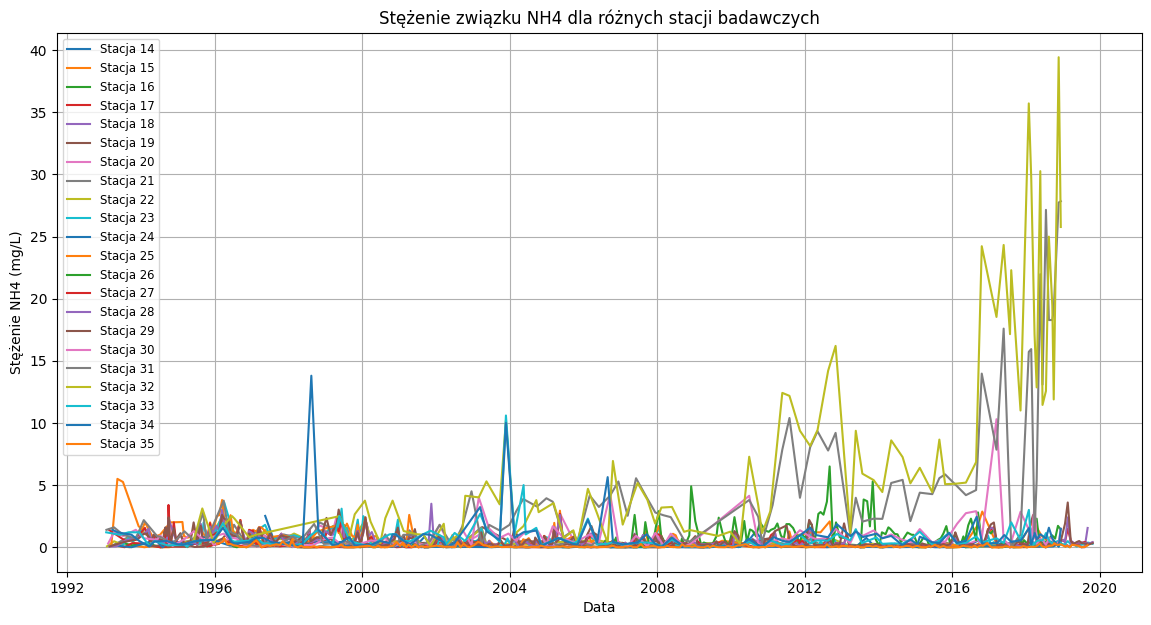

In [ ]:

data = pd.read_csv('data//PB_1996_2019_NH4.csv', sep=';')

data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y')

data.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
for station in data['ID_Station'].unique():
    station_data = data[data['ID_Station'] == station]
    plt.plot(station_data.index, station_data['NH4'], label=f'Stacja {station}')

plt.title('Stężenie związku NH4 dla różnych stacji badawczych')
plt.xlabel('Data')
plt.ylabel('Stężenie NH4 (mg/L)')
plt.legend()
plt.grid(True)
plt.legend(fontsize='small')  

plt.show()

## 1. Wizualizacja danych

### ID  = 29 (tak wybrałyśmy)

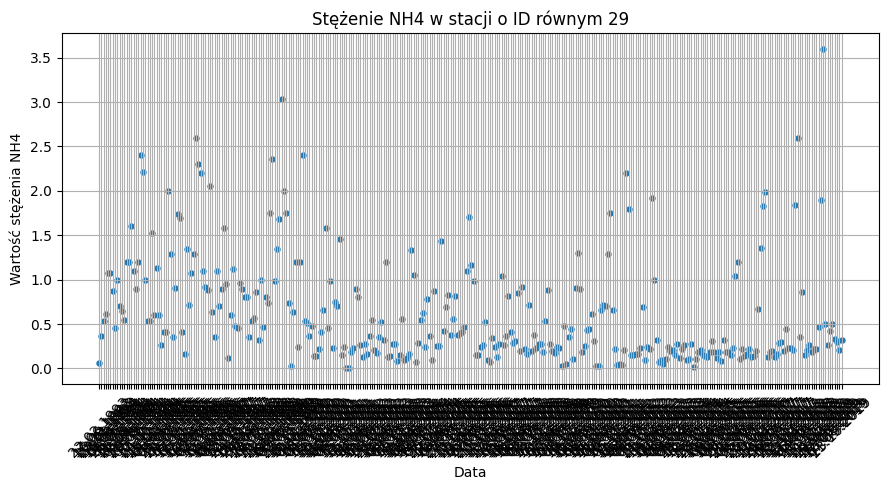

322


In [ ]:
station_num = 29
station_data = data[data['ID_Station'] == station_num]


data_sorted = data.sort_values(by='Date')
plt.figure(figsize=(9, 5))
plt.scatter(station_data['Date'], station_data['NH4'], marker='o', linestyle='-', s=13)
plt.title('Stężenie NH4 w stacji o ID równym 29')
plt.xlabel('Data')
plt.ylabel('Wartość stężenia NH4')
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
print(len(station_data))

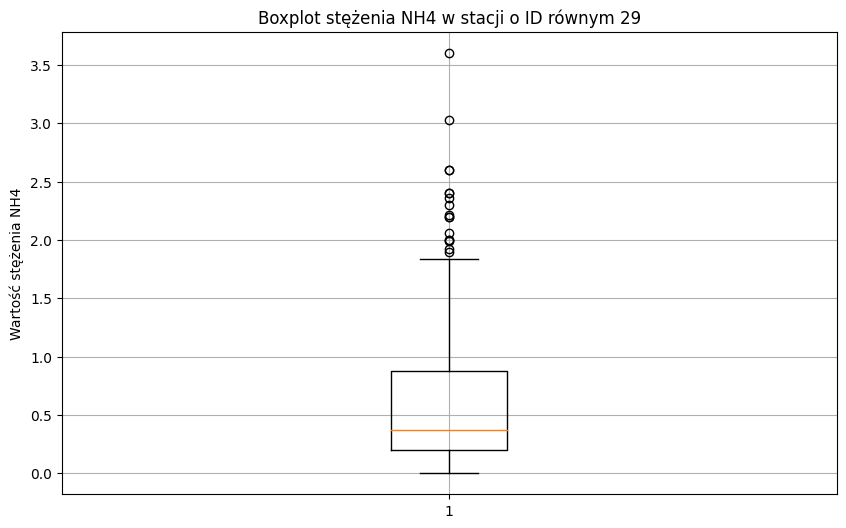

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(station_data['NH4'])
plt.title('Boxplot stężenia NH4 w stacji o ID równym 29')
plt.ylabel('Wartość stężenia NH4')
plt.grid(True)
plt.show()

## 2. Podział danych do przyszłej predykcji

In [ ]:
train_data = station_data[:int(0.9*len(station_data))]
test_data = station_data[int(0.9*len(station_data)):]

322


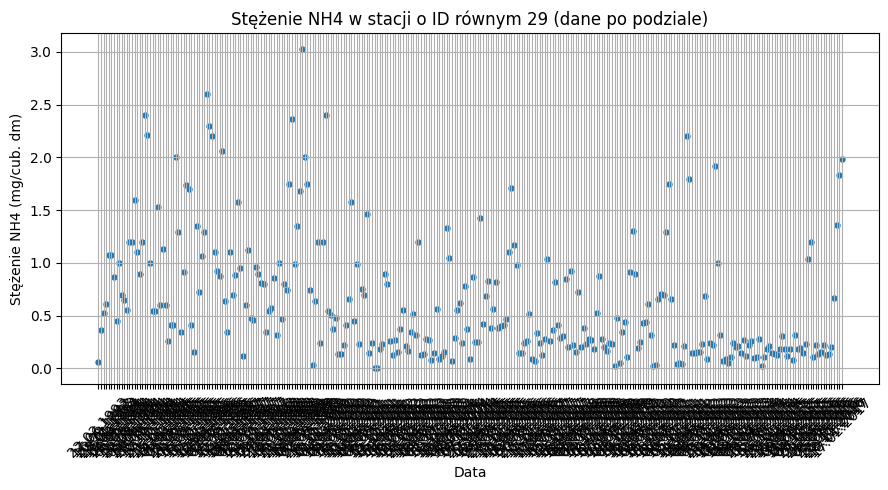

In [ ]:
plt.figure(figsize=(9, 5))
plt.scatter(train_data['Date'], train_data['NH4'], marker='o', linestyle='-', s=13)
plt.title('Stężenie NH4 w stacji o ID równym 29 (dane po podziale)')
plt.xlabel('Data')
plt.ylabel('Stężenie NH4 (mg/cub. dm)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

print(len(station_data))

## 3. Usuwanie trendu i sezonowości

In [ ]:
X = train_data['NH4']
t_list = np.arange(0,(len(X)),1)
a, b = np.polyfit(t_list, X, deg=1)
n = len(train_data)

X_no_trend = np.zeros(n)

for t in range(1,n):
    X_no_trend[t] =  X[t+2357] - a*t - b
    

def decomposition_func(station):
    station_data = train_data[train_data['ID_Station'] == station]
    station_data.set_index('Date', inplace=True)
    station_data = station_data.dropna()
    #decomposition = seasonal_decompose(station_data['NH4'], model='additive', period=12)  # Okres = 12 miesięcy
    
    decomposition = seasonal_decompose(station_data['NH4'], model='additive', period=12)  # Okres = 12 miesięcy

    plt.figure(figsize=(8, 8))
    # szereg oryginalny

    plt.subplot(311)
    plt.title(f"Dekompozycja szeregu stężenia NH4 na stacji {station}")

    plt.plot(station_data.index, station_data['NH4'], label='Szereg oryginalny po podziale', linewidth=3/2)
    plt.grid()
    plt.legend(loc='best')

    # dekompozycja szeregu z podzialem na 3 komponenty
    plt.subplot(312)
    plt.plot(station_data.index, station_data['NH4'], label='Szereg oryginalny', linewidth=3/2)
    plt.plot(station_data.index, decomposition.seasonal,label='Sezonowość')
    plt.plot(station_data.index, decomposition.trend, label='Trend')

    plt.legend(loc='best')
    plt.grid()

    plt.subplot(313)
    # szereg po usunieciu sezonowosci i trendu
    station_data['NH4_detrended_deseasonalized'] = station_data['NH4'] - decomposition.trend - decomposition.seasonal

    plt.plot(station_data.index, station_data['NH4_detrended_deseasonalized'], label='Szereg stacjonarny', linewidth=3/2)
    plt.legend(loc='best')
    plt.grid()

    plt.tight_layout()


# Badanie sezonowości dla stacji numer 14
decomposition_func(14)


plt.figure(figsize=(9, 5))
 
plt.scatter(t_list,X_no_trend, marker='o', linestyle='-', s=13)
plt.title("Stężenie NH4 w stacji o ID równym 29 (bez trendu)")
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

ValueError: x must have 2 complete cycles requires 24 observations. x only has 0 observation(s)

Text(0.5, 11.172785931815357, 'Kolejne numery dni pomiarowych')

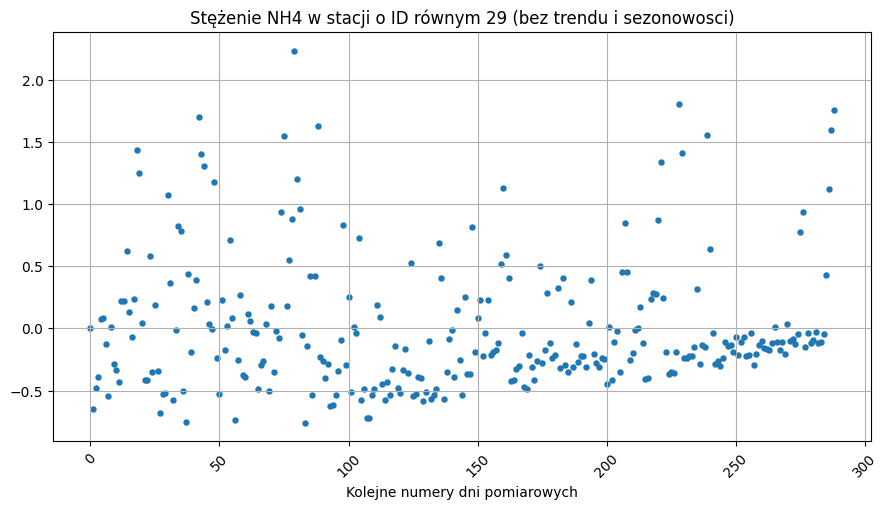

In [ ]:
def funcc(x,c,d,e):
    y = c*np.sin(d*x+e)
    return y

params, sth = curve_fit(funcc, t_list, X_no_trend, p0 = [3,0.004,0])
hat_c, hat_d, hat_e = params

X_no_seasonality = np.zeros(n)

for t in range(1,n):
    X_no_seasonality[t] =  X_no_trend[t] - hat_c*np.sin(hat_d*t+hat_e)

plt.figure(figsize=(9, 5))

plt.scatter(t_list, X_no_seasonality, marker='o', linestyle='-', s=13)
plt.title("Stężenie NH4 w stacji o ID równym 29 (bez trendu i sezonowosci)")
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.xlabel('Kolejne numery dni pomiarowych') 


## 4. Dopasowanie modelu ARMA(p,q)

In [ ]:
station_data_clean = X_no_seasonality

model2 = pm.auto_arima(station_data_clean, 
                      d=0,
                      start_p=0, start_q=0, max_d=0, 
                      max_p=4, max_q=4, max_order=6,
                      trace=True, seasonal=False,
                      #suppress_warnings=True, 
                      stepwise=False
                      )

print(model2.summary())

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=450.560, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=391.238, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=387.404, Time=0.02 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=389.321, Time=0.05 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=389.146, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=388.036, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=387.610, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=388.837, Time=0.08 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=390.245, Time=0.09 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=391.100, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=387.839, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=389.608, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=390.755, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=390.874, Time=0.11 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=392.701, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0]  

Obserwujemy że najlepiej dopasowany jest model ARMA(0,2) ze wspolczynnikami MA: 0.5010 oraz 0.1372. 

In [ ]:
p, q = 0, 2

# Współczynniki modelu MA(2)
ma_params = [1, 0.5010, 0.1372]
sigma2 = 0.2189

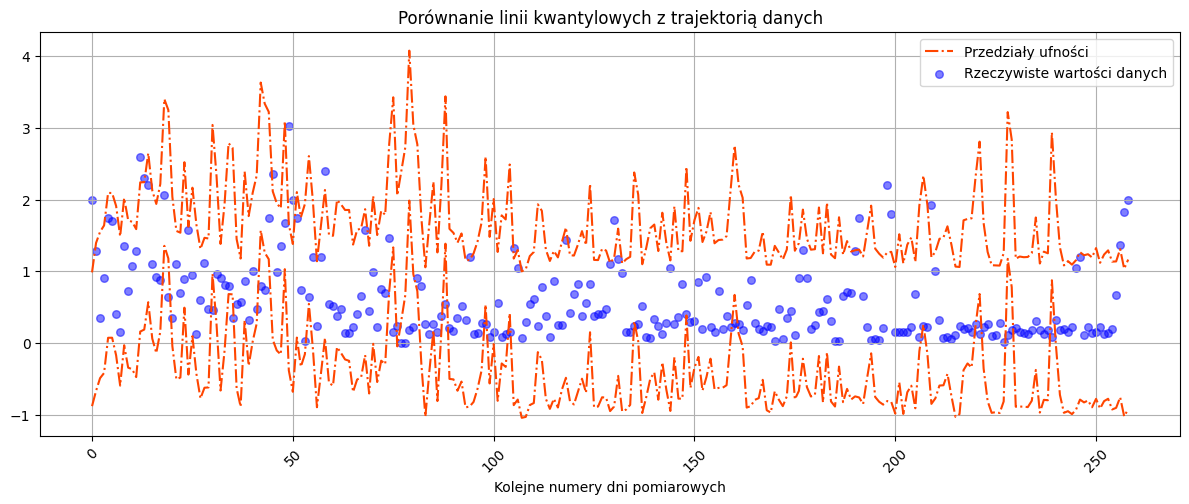

In [ ]:
train_data_NH4 = train_data['NH4']

okres_sez = 30

# Liczba próbek i długość danych
N = 10000
n = len(train_data[okres_sez:])

# Generowanie trajektorii ARMA
ar_models = [arma_generate_sample(ar=[1], ma=ma_params, nsample=n, scale=np.sqrt(sigma2) ) for _ in range(N)]
ar_seasonal_models = [ar_model + train_data_NH4[:-okres_sez] for ar_model in ar_models]

# Obliczanie kwantyli dla przedziału ufności
alpha = 0.05
quantiles_lower = np.quantile(ar_seasonal_models, alpha/2, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha/2, axis=0) 

# Rysowanie wykresu
plt.figure(figsize=(12, 5)) 
line1, = plt.plot(range(n), quantiles_lower, c='orangered', linewidth=3/2, linestyle="dashdot") 
line2, = plt.plot(range(n), quantiles_upper, c='orangered', linewidth=3/2, linestyle="dashdot") 
line3 = plt.scatter(range(n), train_data_NH4[okres_sez:], s=30, c='blue', alpha=0.5) 
plt.legend([line1, line3], ['Przedziały ufności', 'Rzeczywiste wartości danych']) 
plt.xlabel('Kolejne numery dni pomiarowych') 
plt.grid() 
plt.title("Porównanie linii kwantylowych z trajektorią danych")
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Obliczanie procentu danych w przedziale ufności
in_confidence_interval = np.logical_and(train_data_NH4[okres_sez:] >= quantiles_lower, train_data_NH4[okres_sez:] <= quantiles_upper)
percentage_in_confidence_interval = np.mean(in_confidence_interval) * 100

print("Procent danych w przedziale ufności: {:.2f}%".format(percentage_in_confidence_interval))


Procent danych w przedziale ufności: 85.71%


ValueError: x and y must have same first dimension, but have shapes (33,) and (259,)

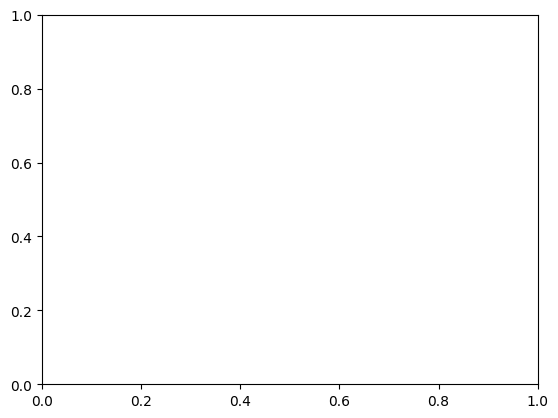

In [ ]:
n = len(test_data)

N = 10000
okres_sez=35
#ar_models = [arma_generate_sample(ar=[1], ma=ma_params, nsample=n ) for _ in range(N)]
#ar_seasonal_models = [ar_model + train_data_NH4[-okres_sez:-okres_sez+n] for ar_model in ar_models]

quantiles_lower = np.quantile(ar_seasonal_models, alpha/2, axis=0)
quantiles_upper = np.quantile(ar_seasonal_models, 1 - alpha/2, axis=0)
line1, = plt.plot(range(n), quantiles_lower, c='C1')
line2, = plt.plot(range(n), quantiles_upper, c='C1')
line3 = plt.scatter(range(n), test_data['NH4'], s=40, c='blue', alpha=0.65)
plt.legend([line1, line3], ['Przedziały ufności', 'Rzeczywiste wartości danych'])
plt.xlabel('t')
plt.ylabel('średnia temperatura ($C^\circ$)')
plt.grid()


## 5. Wyznaczenie przedziałów ACF i PACF

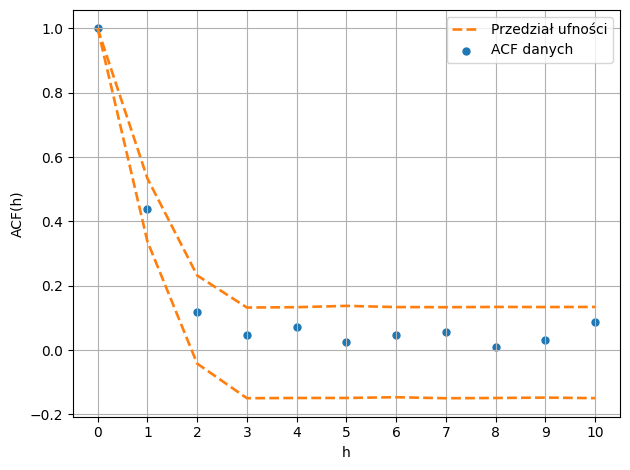

In [ ]:
h = 10

correlation_matrix = np.array([tools.acf(m, nlags=h) for m in ar_models])
alpha = 0.05
quantiles_lower = np.quantile(correlation_matrix, alpha/2, axis=0)
quantiles_upper = np.quantile(correlation_matrix, 1 - alpha/2, axis=0)

line1, = plt.plot(range(h+1), quantiles_lower, linestyle="dashed", color="C1",linewidth=1.9)
plt.plot(range(h+1), quantiles_upper,  linestyle="dashed", color="C1",linewidth=1.9)
line2 = plt.scatter(range(h+1), tools.acf(station_data_clean, nlags=h), s=25)
plt.xlabel('h')
plt.ylabel('ACF(h)')
plt.legend([line1, line2], ['Przedział ufności', 'ACF danych'])
plt.xticks(ticks=range(0,11))
plt.grid()
plt.tight_layout()


([<matplotlib.axis.XTick at 0x208c01e1880>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

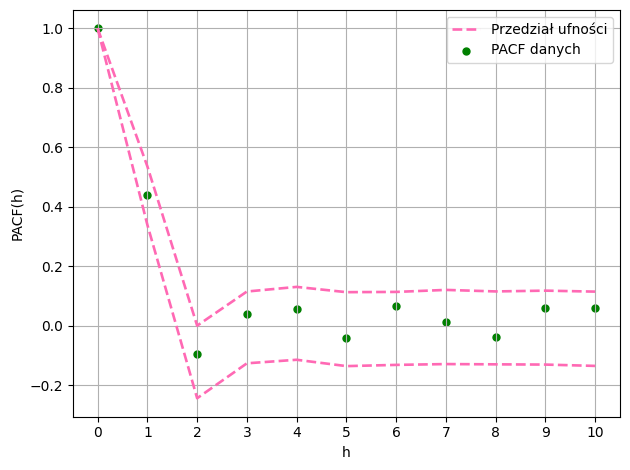

In [ ]:
h= 10
partial_correlation_matrix = np.array([tools.pacf(m, nlags=h) for m in ar_models])
alpha = 0.05
quantiles_lower = np.quantile(partial_correlation_matrix, alpha/2, axis=0)
quantiles_upper = np.quantile(partial_correlation_matrix, 1 - alpha/2, axis=0)

line1, = plt.plot(range(h+1), quantiles_lower, c='hotpink', linestyle="dashed", linewidth=1.9)
plt.plot(range(h+1), quantiles_upper,linestyle="dashed", color="hotpink",linewidth=1.9)
line2 = plt.scatter(range(h+1), tools.pacf(station_data_clean, nlags=h), color="g", s=25)
plt.xlabel('h')
plt.ylabel('PACF(h)')
plt.grid()
plt.tight_layout()
plt.legend([line1, line2], ['Przedział ufności', 'PACF danych'])
plt.xticks(ticks=range(0,11))
